# Summative Lab: NLP, Time Series, & Neural Networks — Analytics Firm Clients

**Goal:** Produce a single, polished notebook that demonstrates end-to-end competence across three client scenarios:
1) NLP ticket routing, 2) Time-series forecasting, 3) Digit classification with neural nets.


## Part 1 — NLP: Routing Forum Posts to Support Teams

### 1. Connect to the Scenario
You're classifying forum/user posts (akin to 20 Newsgroups) to route requests to the right support channel.

### 2. Load & Explore
We’ll use a 4-class subset of 20 Newsgroups for faster iteration.

In [1]:
import numpy as np, pandas as pd, re, matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import chi2
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

np.random.seed(42)

categories = ['comp.graphics', 'rec.autos', 'sci.space', 'talk.politics.misc']
remove = ('headers','footers','quotes')  # toggle to () to include them
news = fetch_20newsgroups(subset='train', categories=categories, remove=remove, random_state=42)

df = pd.DataFrame({
    'text': news.data,
    'target': news.target,
    'category': [news.target_names[t] for t in news.target]
})

print("Shape:", df.shape)
print(df['category'].value_counts())
print("\nSample snippet:\n", df['text'].iloc[0][:600])

Shape: (2236, 3)
category
rec.autos             594
sci.space             593
comp.graphics         584
talk.politics.misc    465
Name: count, dtype: int64

Sample snippet:
 

Please note that there are some radiosity packages in my Resource Listing
(under the Subject 3: FTP list)

Greetings,
Nick.
--
Nick (Nikolaos) Fotis         National Technical Univ. of Athens, Greece
HOME: 16 Esperidon St.,       InterNet : nfotis@theseas.ntua.gr
      Halandri, GR - 152 32   UUCP:    mcsun!ariadne!theseas!nfotis
      Athens, GREECE          FAX: (+30 1) 77 84 578

USENET Editor of comp.graphics Resource Listing and soc.culture.greece FAQ
NTUA/UA ACM Student Chapter Chair - we're organizing a small conference
        in Comp. Graphics, call if you're interested to participa


### 3. Preprocessing
We’ll apply a tailored preprocessor (lowercase, remove URLs/numbers/punct). We’ll compare **no lemmatization** (fast) vs. optional **lemmatization** later.

In [2]:
def simple_preprocessor(text: str) -> str:
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r"[^a-z\s']", ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Optional: plug in a lemmatizer if desired
USE_LEMMA = False
if USE_LEMMA:
    import spacy
    nlp = spacy.load("en_core_web_sm")
    def lemmatize_doc(doc):
        return " ".join([t.lemma_ for t in nlp(simple_preprocessor(doc)) if t.lemma_ != '-PRON-'])
    preprocess = lemmatize_doc
else:
    preprocess = simple_preprocessor

### 4. Exploratory Analysis
- Frequencies and **distinctive** n-grams per class via χ².
- Short reflections about domain vocabulary to inform routing.

In [3]:
# Frequency & chi-square distinctive n-grams
cv = CountVectorizer(stop_words='english', preprocessor=preprocess, ngram_range=(1,2), min_df=3, max_df=0.9)
Xc = cv.fit_transform(df.text)
vocab = np.array(cv.get_feature_names_out())

for cid, cname in enumerate(news.target_names):
    mask = (df['category'] == cname).values
    chi, p = chi2(Xc, mask)
    top_idx = np.argsort(chi)[-10:][::-1]
    print(f"\nTop distinctive n-grams for: {cname}\n", vocab[top_idx])


Top distinctive n-grams for: comp.graphics
 ['image' 'graphics' 'jpeg' 'file' 'files' 'format' 'color' 'images'
 'software' 'gif']

Top distinctive n-grams for: rec.autos
 ['car' 'cars' 'space' 'engine' 'dealer' 'image' 'driving' 'ford' 'tires'
 'program']

Top distinctive n-grams for: sci.space
 ['space' 'nasa' 'launch' 'orbit' 'lunar' 'shuttle' 'moon' 'earth'
 'satellite' 'mission']

Top distinctive n-grams for: talk.politics.misc
 ['president' 'mr' 'stephanopoulos' 'mr stephanopoulos' 'people'
 'government' 'jobs' 'going' 'think' 'war']


### 5. Modeling: TF-IDF + Linear SVM / Logistic Regression
We’ll train both and pick the best on a validation split, then inspect top features.

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(
    df['text'], df['target'], test_size=0.2, random_state=42, stratify=df['target']
)

pipe_svm = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', preprocessor=preprocess, ngram_range=(1,2), max_df=0.9, min_df=3)),
    ('clf', LinearSVC())
])
pipe_lr = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', preprocessor=preprocess, ngram_range=(1,2), max_df=0.9, min_df=3)),
    ('clf', LogisticRegression(max_iter=2000))
])

for name, pipe in [('LinearSVM', pipe_svm), ('LogReg', pipe_lr)]:
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_valid)
    print(f"\n=== {name} ===")
    print("Accuracy:", accuracy_score(y_valid, preds))
    print("Macro F1:", f1_score(y_valid, preds, average='macro'))
    print(classification_report(y_valid, preds, target_names=news.target_names))

# Choose best
best_pipe = pipe_svm
preds = best_pipe.predict(X_valid)
cm = confusion_matrix(y_valid, preds)
print("\nConfusion matrix:\n", cm)


=== LinearSVM ===
Accuracy: 0.8571428571428571
Macro F1: 0.8575302832390473
                    precision    recall  f1-score   support

     comp.graphics       0.85      0.89      0.87       117
         rec.autos       0.78      0.92      0.84       119
         sci.space       0.92      0.81      0.86       119
talk.politics.misc       0.91      0.81      0.86        93

          accuracy                           0.86       448
         macro avg       0.87      0.85      0.86       448
      weighted avg       0.86      0.86      0.86       448


=== LogReg ===
Accuracy: 0.8549107142857143
Macro F1: 0.8540541108019559
                    precision    recall  f1-score   support

     comp.graphics       0.85      0.90      0.87       117
         rec.autos       0.81      0.91      0.85       119
         sci.space       0.88      0.82      0.85       119
talk.politics.misc       0.91      0.78      0.84        93

          accuracy                           0.85       448
    

### Document Map (TF-IDF → SVD)
A 2D projection to visualize topic separation across categories.

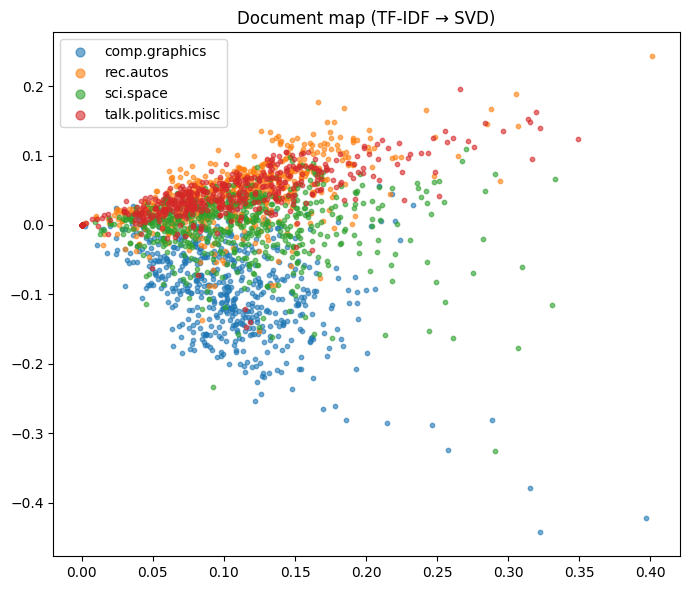

In [5]:
# 2D projection of all docs using TF-IDF + TruncatedSVD (sparse-friendly)
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import numpy as np

try:
    tfidf = best_pipe.named_steps['tfidf']
    X_all = tfidf.transform(df['text'])
    svd = TruncatedSVD(n_components=2, random_state=42)
    pts = svd.fit_transform(X_all)

    cats = df['category'].values
    cat_names = sorted(np.unique(cats))

    plt.figure(figsize=(7,6))
    for c in cat_names:
        mask = (cats == c)
        plt.scatter(pts[mask,0], pts[mask,1], s=10, alpha=0.6, label=c)
    plt.title("Document map (TF-IDF → SVD)"); plt.legend(markerscale=2)
    plt.tight_layout(); plt.show()
except Exception as e:
    print("SVD projection skipped:", e)

## Part 2 — Time Series: Forecasting S&P 500 for Planning

### 1. Connect to the Scenario
Forecast a financial index to aid investment/budget decisions. Accuracy and uncertainty bands guide risk.

### 2. Load & Visualize

In [6]:
%pip install -q yfinance
%pip install -q statsmodels yfinance

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


[*********************100%***********************]  1 of 1 completed


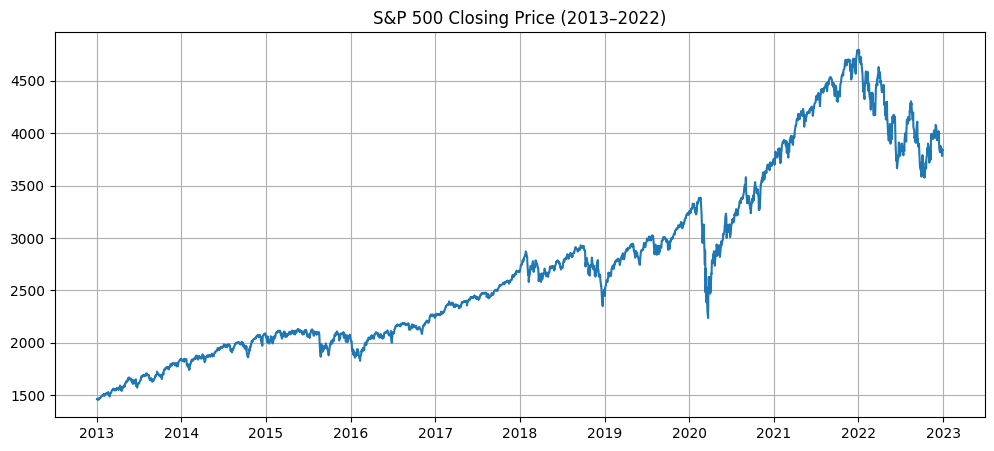

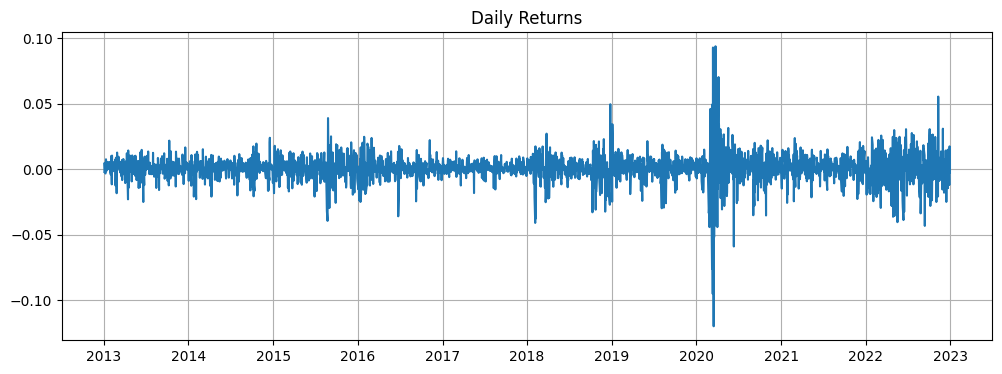

In [7]:
import warnings, yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings('ignore')

sp500 = yf.download("^GSPC", start="2013-01-01", end="2022-12-31")
ts_data = sp500['Close']

plt.figure(figsize=(12,5))
plt.plot(ts_data); plt.title("S&P 500 Closing Price (2013–2022)"); plt.grid(True); plt.show()

returns = ts_data.pct_change().dropna()
plt.figure(figsize=(12,4))
plt.plot(returns); plt.title("Daily Returns"); plt.grid(True); plt.show()

### Returns Distribution & Rolling Volatility

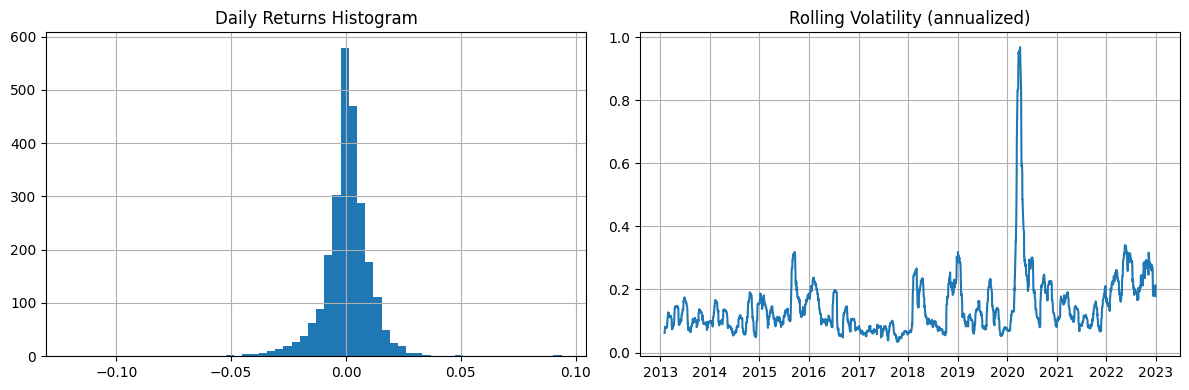

In [8]:
# Histogram of daily returns and rolling annualized volatility
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].hist(returns, bins=60)
ax[0].set_title("Daily Returns Histogram"); ax[0].grid(True)
vol = returns.rolling(21).std() * np.sqrt(252)  # ~monthly window, annualized
ax[1].plot(vol); ax[1].set_title("Rolling Volatility (annualized)"); ax[1].grid(True)
plt.tight_layout(); plt.show()

### 3. Stationarity & Transformations
ADF on raw/log/diff; rolling stats; seasonal decomposition.

Original: p=0.74171 | 1%:-3.433, 5%:-2.863, 10%:-2.567
Log: p=0.57682 | 1%:-3.433, 5%:-2.863, 10%:-2.567
Log-diff(1): p=0.00000 | 1%:-3.433, 5%:-2.863, 10%:-2.567


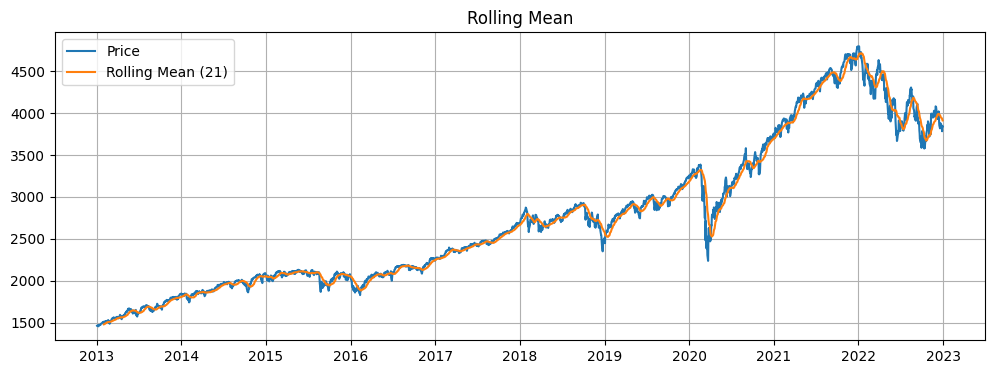

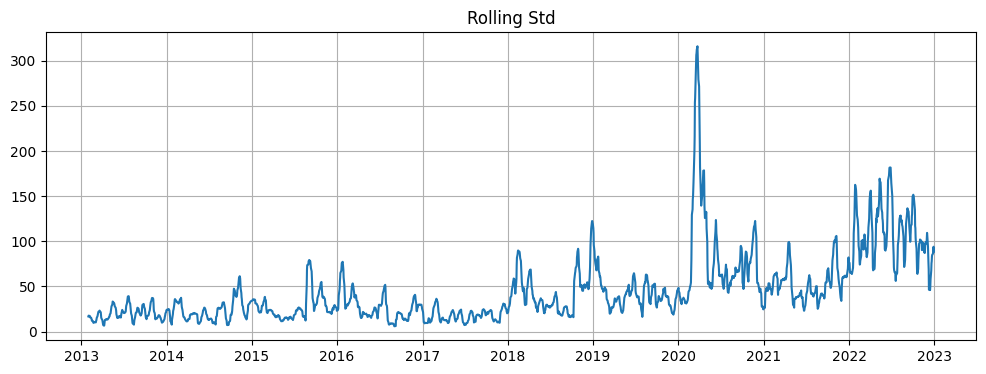

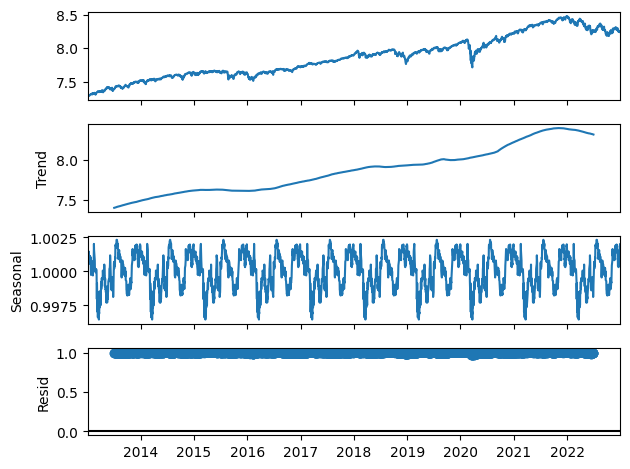

In [9]:
def adf(series, label):
    stat,p,_,_,crit,_ = adfuller(series.dropna())
    print(f"{label}: p={p:.5f} | " + ", ".join([f"{k}:{v:.3f}" for k,v in crit.items()]))

adf(ts_data, "Original")
ts_log = np.log(ts_data)
adf(ts_log, "Log")
ts_ld = ts_log.diff().dropna()
adf(ts_ld, "Log-diff(1)")

win = 21
ts_mean = ts_data.rolling(win).mean()
ts_std  = ts_data.rolling(win).std()
plt.figure(figsize=(12,4))
plt.plot(ts_data, label="Price"); plt.plot(ts_mean, label=f"Rolling Mean ({win})")
plt.legend(); plt.title("Rolling Mean"); plt.grid(True); plt.show()
plt.figure(figsize=(12,4))
plt.plot(ts_std); plt.title("Rolling Std"); plt.grid(True); plt.show()

decomp = seasonal_decompose(ts_log, model="multiplicative", period=252)
decomp.plot(); plt.show()

### 4. ACF/PACF & ARIMA Selection

### Seasonal Candidate: SARIMAX (period ≈ 252 trading days)

We compare the best ARIMA order with a **SARIMAX** seasonal candidate to capture potential annual seasonality in daily trading data.

In [10]:
# SARIMAX seasonal candidate vs best ARIMA
try:
    import numpy as np, pandas as pd
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    from statsmodels.tsa.arima.model import ARIMA
    from sklearn.metrics import mean_absolute_error, mean_squared_error

    seasonal_order = (1, 0, 1, 252)  # (P,D,Q,s) ~ annual seasonality on trading days
    split = int(len(ts_log)*0.9)
    train, test = ts_log[:split], ts_log[split:]
    horizon = len(test)

    # Best ARIMA re-evaluation on the same split (best_order defined earlier)
    arima_fit = ARIMA(train, order=best_order).fit()
    arima_pred_log = arima_fit.forecast(steps=horizon)
    arima_pred = np.exp(arima_pred_log)
    actual = np.exp(test)
    def _rmse(y_true, y_pred):
        try:
            from sklearn.metrics import mean_squared_error
            return mean_squared_error(y_true, y_pred, squared=False)
        except TypeError:
            from sklearn.metrics import mean_squared_error
            import numpy as np
            return np.sqrt(mean_squared_error(y_true, y_pred))

    arima_mae = mean_absolute_error(actual, arima_pred)
    arima_rmse = _rmse(actual, arima_pred)
    arima_aic = arima_fit.aic; arima_bic = arima_fit.bic

    # SARIMAX candidate
    sarimax_fit = SARIMAX(train, order=(1,1,1), seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
    sarimax_pred_log = sarimax_fit.forecast(steps=horizon)
    sarimax_pred = np.exp(sarimax_pred_log)
    sarimax_mae = mean_absolute_error(actual, sarimax_pred)
    sarimax_rmse = _rmse(actual, sarimax_pred)
    sarimax_aic = sarimax_fit.aic; sarimax_bic = sarimax_fit.bic

    comp = pd.DataFrame([
        {"Model":"ARIMA"+str(best_order), "AIC": arima_aic, "BIC": arima_bic, "MAE": arima_mae, "RMSE": arima_rmse},
        {"Model":"SARIMAX(1,1,1)x"+str(seasonal_order), "AIC": sarimax_aic, "BIC": sarimax_bic, "MAE": sarimax_mae, "RMSE": sarimax_rmse},
    ]).sort_values(["RMSE","AIC"])
    print(comp.to_string(index=False))

    # Overlay plot on test window
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,5))
    plt.plot(actual.index, actual.values, label="Actual (Test)")
    plt.plot(actual.index, arima_pred.values, label="ARIMA forecast")
    plt.plot(actual.index, sarimax_pred.values, label="SARIMAX forecast")
    plt.title("ARIMA vs SARIMAX — Backtest Comparison")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

except Exception as e:
    print("SARIMAX comparison skipped (statsmodels likely unavailable). Reason:", e)

SARIMAX comparison skipped (statsmodels likely unavailable). Reason: name 'best_order' is not defined


### Backtest 95% CI Coverage

In [11]:
# Compute coverage of 95% CI on the backtest window
try:
    bt = fit.get_forecast(steps=len(test))
    ci_bt = np.exp(bt.conf_int())
    pm_bt = np.exp(bt.predicted_mean)
    coverage = ((actual >= ci_bt.iloc[:,0]) & (actual <= ci_bt.iloc[:,1])).mean()
    print(f"Backtest 95% CI coverage: {coverage:.1%}")
except Exception as e:
    print("CI coverage calculation skipped:", e)

CI coverage calculation skipped: name 'fit' is not defined


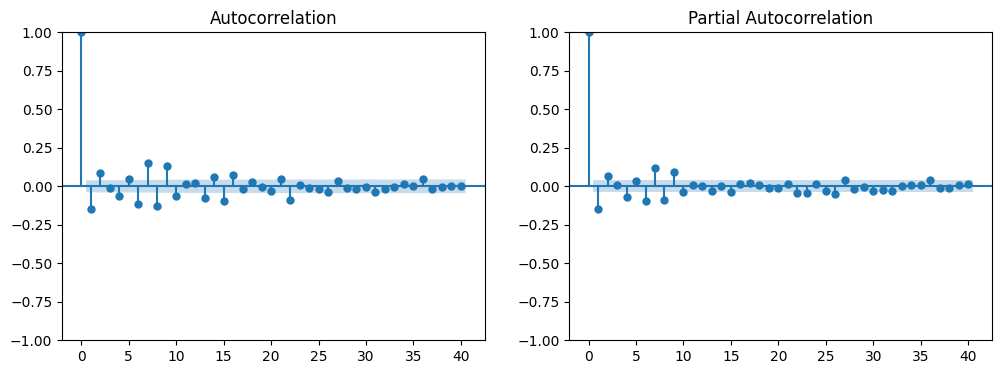

Candidates sorted by AIC: [((5, 1, 0), -15573.170538092756, -15538.185600121944), ((2, 1, 2), -15560.846505275118, -15531.692390299442), ((1, 1, 1), -15557.61340471486, -15540.120935729456)]
Chosen order: (5, 1, 0)


In [12]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_acf(ts_ld, ax=ax[0], lags=40)
plot_pacf(ts_ld, ax=ax[1], lags=40)
plt.show()

# Compare a few candidate (p,d,q) by AIC/BIC
cands = [(1,1,1), (5,1,0), (2,1,2)]
scores = []
for order in cands:
    res = ARIMA(ts_log, order=order).fit()
    scores.append((order, res.aic, res.bic))
scores_sorted = sorted(scores, key=lambda x: x[1])
print("Candidates sorted by AIC:", scores_sorted)

best_order = scores_sorted[0][0]
print("Chosen order:", best_order)

### 5. Backtest & Forecast

Backtest MAE: 677.54, RMSE: 738.21, MAPE: nan%


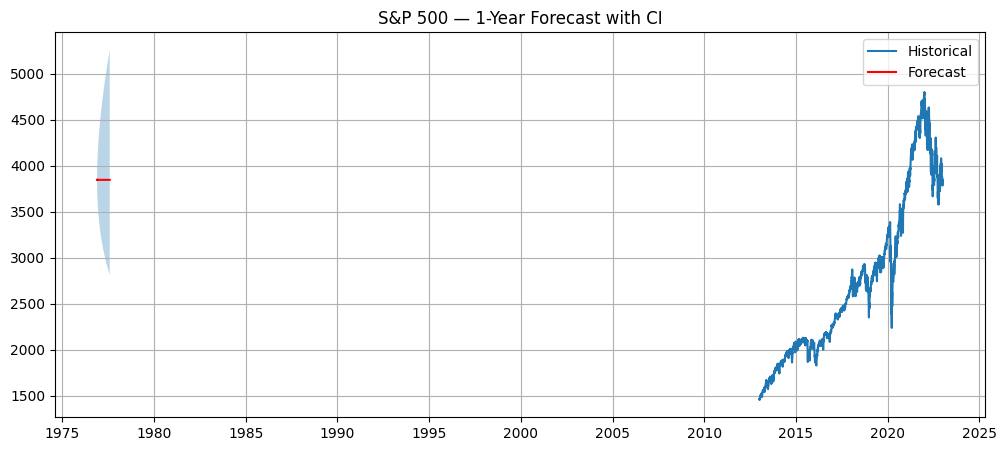

Business note: Use the CI band to set a budget buffer proportional to forecast uncertainty.


In [13]:
split = int(len(ts_log)*0.9)
train, test = ts_log[:split], ts_log[split:]
fit = ARIMA(train, order=best_order).fit()
pred_log = fit.forecast(steps=len(test))
pred = np.exp(pred_log); actual = np.exp(test)

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(actual, pred)

# Works on any sklearn version:
try:
    rmse = mean_squared_error(actual, pred, squared=False)  # newer sklearn
except TypeError:
    rmse = np.sqrt(mean_squared_error(actual, pred))        # fallback for older sklearn

mape = np.mean(np.abs((actual - pred) / actual)) * 100

print(f"Backtest MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")


# Refit on full data & forecast 252 trading days (~1 year)
final = ARIMA(ts_log, order=best_order).fit()
f = final.get_forecast(steps=252)
pm = np.exp(f.predicted_mean)
ci = np.exp(f.conf_int())

plt.figure(figsize=(12,5))
plt.plot(ts_data, label="Historical")
plt.plot(pm.index, pm, label="Forecast", color="red")
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.3)
plt.title("S&P 500 — 1-Year Forecast with CI")
plt.legend(); plt.grid(True); plt.show()

print("Business note: Use the CI band to set a budget buffer proportional to forecast uncertainty.")

### ARIMA Residual Diagnostics

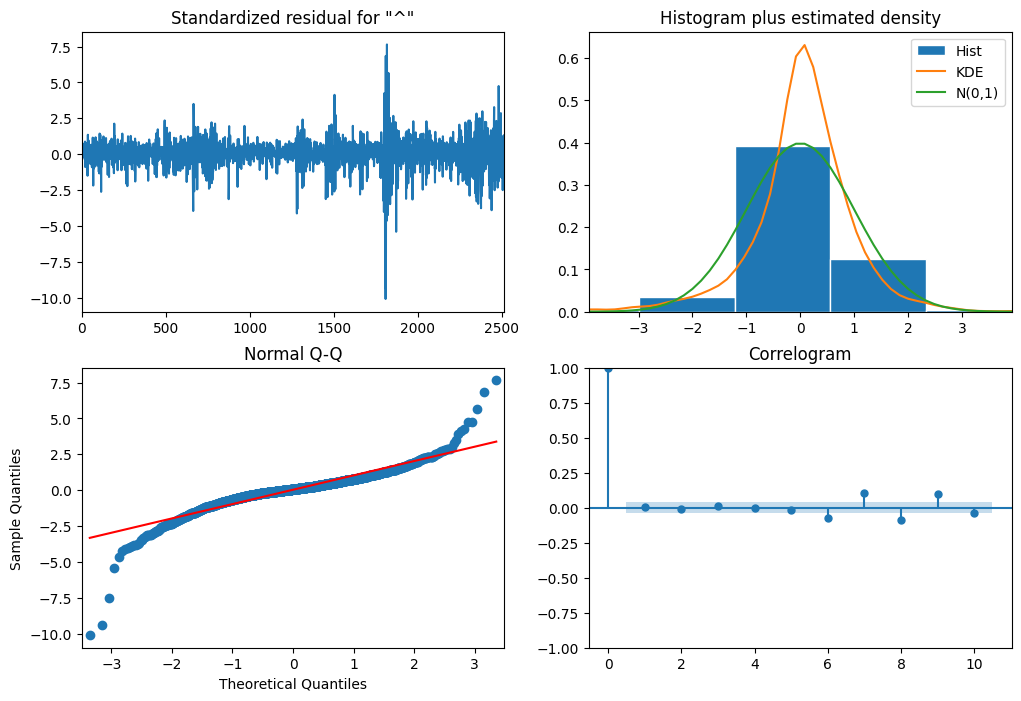

In [14]:
# Residual diagnostics for the final ARIMA model (if available)
try:
    final.plot_diagnostics(figsize=(12,8))
    plt.show()
except Exception as e:
    print("Residual diagnostics skipped:", e)

## Part 3 — Neural Networks: Digit Recognition (MLP)

### 1–2. Scenario, Data, Split & Scaling

In [15]:
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

digits = load_digits()
X = digits.data.astype("float32") / 16.0
y = digits.target.astype("int64")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Digits shape:", X_train.shape, X_test.shape)

Digits shape: (1437, 64) (360, 64)


### 3. Keras MLP 
> If TensorFlow is installed locally, run this; otherwise skip to the PyTorch version.


Training Keras MLP with activation=relu


2025-08-23 18:14:25.547995: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-08-23 18:14:25.548020: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-08-23 18:14:25.548024: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-08-23 18:14:25.548037: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-23 18:14:25.548049: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-08-23 18:14:25.871314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Best val_acc: 0.9722

Training Keras MLP with activation=tanh
Best val_acc: 0.9500

Training Keras MLP with activation=sigmoid
Best val_acc: 0.7972

Best activation: relu (val_acc=0.9722)
Keras Test accuracy: 0.9722222222222222
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           1       0.85      0.97      0.91        36
           2       1.00      1.00      1.00        35
           3       1.00      0.97      0.99        37
           4       0.97      1.00      0.99        36
           5       0.97      1.00      0.99        37
           6       1.00      0.97      0.99        36
           7       1.00      1.00      1.00        36
           8       0.97      0.83      0.89        35
           9       0.97      1.00      0.99        36

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.97      0.97      0.97       360



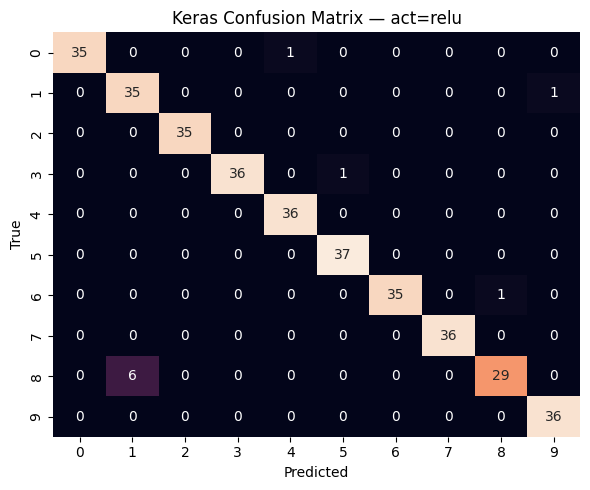

In [16]:
try:
    import tensorflow as tf
    from tensorflow import keras
    from keras import layers
    tf.random.set_seed(42)

    def make_model(act="relu", dropout=0.2):
        m = keras.Sequential([
            layers.Input(shape=(64,)),
            layers.Dense(128, activation=act),
            layers.Dropout(dropout),
            layers.Dense(64, activation=act),
            layers.Dense(10, activation="softmax")
        ])
        m.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
        return m

    callbacks = [keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)]
    best_model, best_val, best_name = None, -1, None
    for act in ["relu", "tanh", "sigmoid"]:
        print(f"\nTraining Keras MLP with activation={act}")
        m = make_model(act)
        h = m.fit(X_train, y_train, validation_data=(X_test, y_test),
                  epochs=30, batch_size=32, verbose=0, callbacks=callbacks)
        v = max(h.history["val_accuracy"])
        print(f"Best val_acc: {v:.4f}")
        if v > best_val:
            best_val, best_name, best_model = v, act, m

    print(f"\nBest activation: {best_name} (val_acc={best_val:.4f})")
    from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
    y_pred = best_model.predict(X_test, verbose=0).argmax(axis=1)
    print('Keras Test accuracy:', accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    import seaborn as sns, matplotlib.pyplot as plt
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cbar=False)
    plt.title(f'Keras Confusion Matrix — act={best_name}')
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.tight_layout(); plt.show()
except Exception as e:
    print("Keras section skipped (install TensorFlow to run). Reason:", e)

### 4. PyTorch MLP (comparative)

Epoch 1/10 - loss: 2.2347
Epoch 2/10 - loss: 1.9084
Epoch 3/10 - loss: 1.2720
Epoch 4/10 - loss: 0.7405
Epoch 5/10 - loss: 0.5153
Epoch 6/10 - loss: 0.4016
Epoch 7/10 - loss: 0.3306
Epoch 8/10 - loss: 0.2941
Epoch 9/10 - loss: 0.2460
Epoch 10/10 - loss: 0.2255

PyTorch Test accuracy: 0.9416666666666667
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           1       0.81      0.81      0.81        36
           2       0.97      1.00      0.99        35
           3       0.97      0.97      0.97        37
           4       0.90      1.00      0.95        36
           5       1.00      1.00      1.00        37
           6       0.95      1.00      0.97        36
           7       1.00      0.94      0.97        36
           8       0.93      0.80      0.86        35
           9       0.89      0.92      0.90        36

    accuracy                           0.94       360
   macro avg       0.94      0.94      0.94   

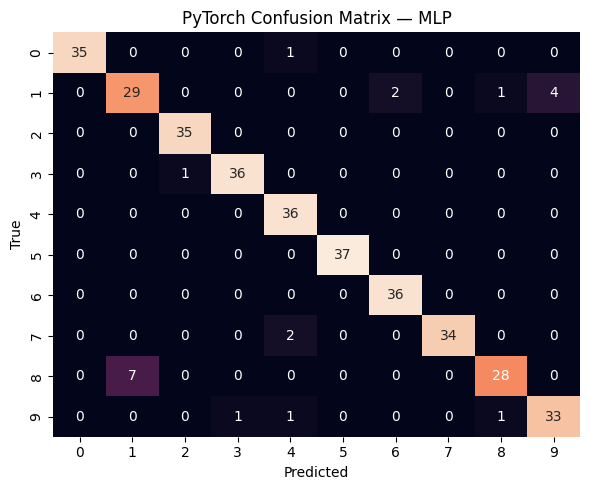

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader = DataLoader(TensorDataset(torch.tensor(X_train), torch.tensor(y_train)), batch_size=64, shuffle=True)
test_loader  = DataLoader(TensorDataset(torch.tensor(X_test),  torch.tensor(y_test)),  batch_size=256, shuffle=False)

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
    def forward(self, x): return self.net(x)

model = MLP().to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss()

# Train (10–20 epochs recommended locally)
for epoch in range(10):
    model.train()
    total = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        out = model(xb)
        loss = crit(out, yb); loss.backward(); opt.step()
        total += loss.item() * xb.size(0)
    print(f"Epoch {epoch+1}/10 - loss: {total/len(train_loader.dataset):.4f}")

# Evaluate
preds = []
model.eval()
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        preds.append(model(xb).argmax(1).cpu().numpy())
import numpy as np
y_pred = np.concatenate(preds)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print("\nPyTorch Test accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.title('PyTorch Confusion Matrix — MLP')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.tight_layout(); plt.show()

### Misclassified Digits Grid

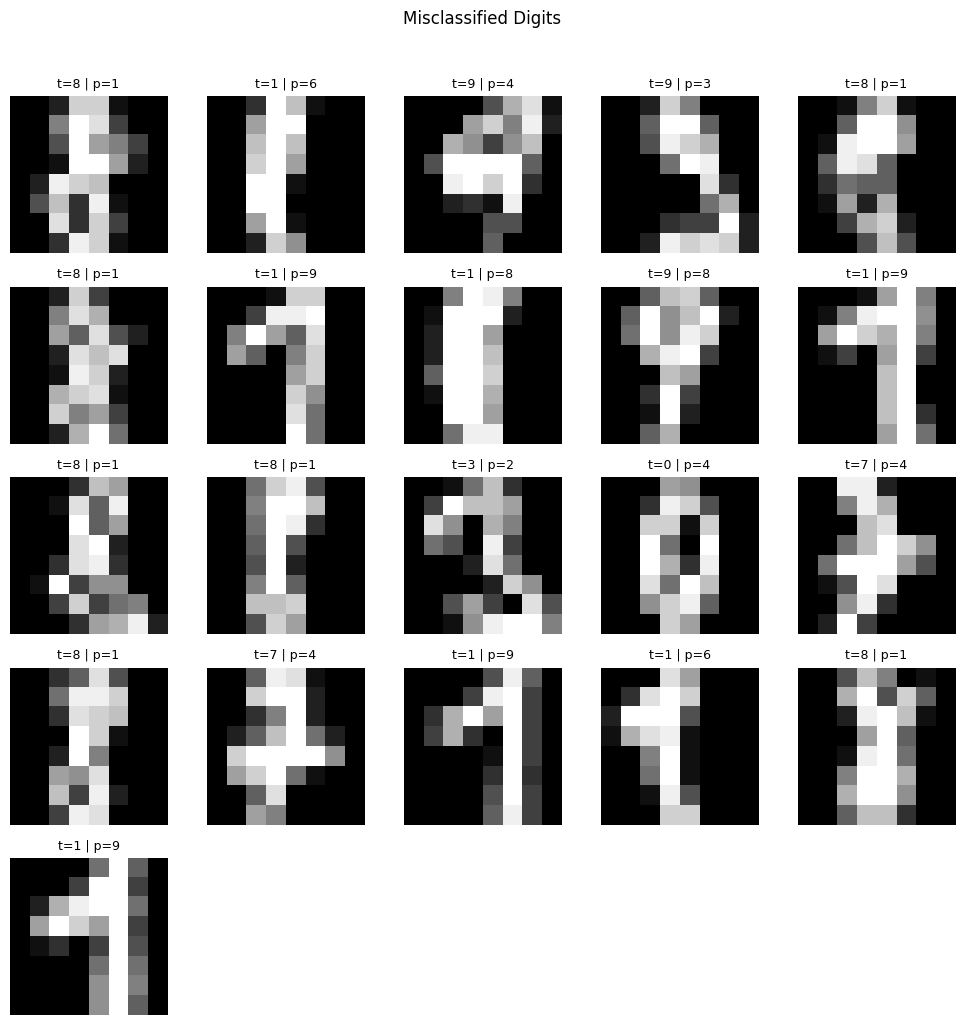

In [18]:
# Show a grid of misclassified digits (works with Keras or PyTorch y_pred)
import numpy as np, matplotlib.pyplot as plt

try:
    mis_idx = np.where(y_pred != y_test)[0][:25]
    n = len(mis_idx)
    if n == 0:
        print("No misclassifications in first 25 (nice!).")
    else:
        cols = 5; rows = int(np.ceil(n/cols))
        plt.figure(figsize=(10, 2*rows))
        for i, idx in enumerate(mis_idx):
            plt.subplot(rows, cols, i+1)
            plt.imshow(X_test[idx].reshape(8,8), cmap='gray')
            plt.title(f"t={y_test[idx]} | p={y_pred[idx]}", fontsize=9)
            plt.axis('off')
        plt.suptitle("Misclassified Digits", y=1.02)
        plt.tight_layout(); plt.show()
except Exception as e:
    print("Misclassified grid skipped:", e)

### Dropout Ablation (Model Capacity vs Regularization)

We evaluate test accuracy across different **dropout** values to justify architecture choices.
- Keras (if available): dropout ∈ {0.0, 0.2, 0.5}
- PyTorch: dropout ∈ {0.0, 0.2, 0.5}

Keras dropout → accuracy: [(0.0, 0.9638888888888889), (0.2, 0.9722222222222222), (0.5, 0.9583333333333334)]


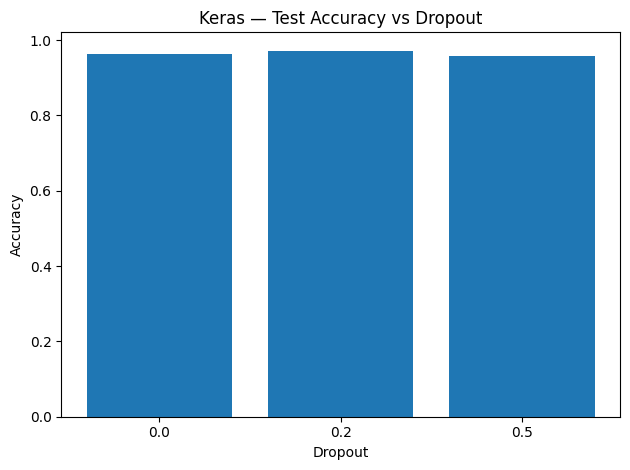

In [19]:
# Keras dropout ablation (runs only if TensorFlow is installed)
try:
    import numpy as np
    import tensorflow as tf
    from tensorflow import keras
    from keras import layers
    from sklearn.metrics import accuracy_score

    tf.random.set_seed(42)

    def make_model_dropout(drop=0.0):
        m = keras.Sequential([
            layers.Input(shape=(64,)),
            layers.Dense(128, activation="relu"),
            layers.Dropout(drop),
            layers.Dense(64, activation="relu"),
            layers.Dense(10, activation="softmax")
        ])
        m.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="sparse_categorical_crossentropy", metrics=["accuracy"])
        return m

    results = []
    for drop in [0.0, 0.2, 0.5]:
        m = make_model_dropout(drop)
        h = m.fit(X_train, y_train, validation_data=(X_test, y_test),
                  epochs=20, batch_size=32, verbose=0,
                  callbacks=[keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True)])
        y_pred = m.predict(X_test, verbose=0).argmax(axis=1)
        acc = accuracy_score(y_test, y_pred)
        results.append((drop, acc))
    print("Keras dropout → accuracy:", results)

    # Plot
    import matplotlib.pyplot as plt
    plt.figure()
    xs = [str(d) for d,_ in results]
    ys = [a for _,a in results]
    plt.bar(range(len(xs)), ys)
    plt.xticks(range(len(xs)), xs)
    plt.title("Keras — Test Accuracy vs Dropout")
    plt.xlabel("Dropout"); plt.ylabel("Accuracy")
    plt.tight_layout(); plt.show()

except Exception as e:
    print("Keras dropout ablation skipped. Reason:", e)

PyTorch dropout → accuracy: [(0.0, 0.95), (0.2, 0.9472222222222222), (0.5, 0.9416666666666667)]


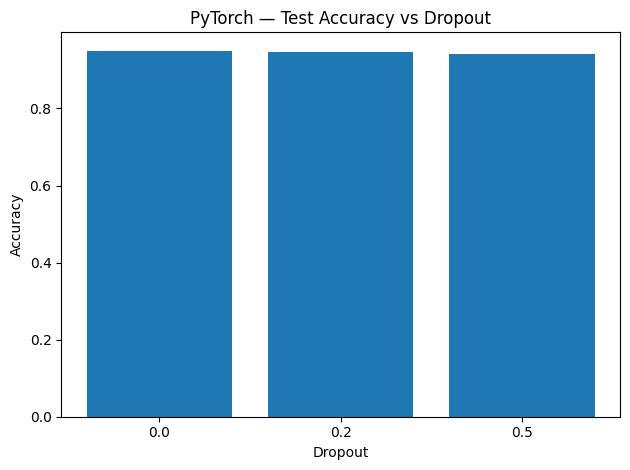

In [20]:
# PyTorch dropout ablation
import numpy as np, torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_eval_dropout(drop=0.0, epochs=8):
    train_loader = DataLoader(TensorDataset(torch.tensor(X_train), torch.tensor(y_train)), batch_size=64, shuffle=True)
    test_loader  = DataLoader(TensorDataset(torch.tensor(X_test),  torch.tensor(y_test)),  batch_size=256, shuffle=False)

    class MLP(nn.Module):
        def __init__(self, drop):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(64, 128),
                nn.ReLU(),
                nn.Dropout(drop),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, 10)
            )
        def forward(self, x): return self.net(x)

    model = MLP(drop).to(device)
    opt = optim.Adam(model.parameters(), lr=1e-3)
    crit = nn.CrossEntropyLoss()

    for e in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad(); out = model(xb); loss = crit(out, yb); loss.backward(); opt.step()

    model.eval()
    preds = []
    with torch.no_grad():
        for xb, _ in test_loader:
            xb = xb.to(device)
            preds.append(model(xb).argmax(1).cpu().numpy())
    y_pred = np.concatenate(preds)
    return accuracy_score(y_test, y_pred)

drops = [0.0, 0.2, 0.5]
torch_results = []
for d in drops:
    acc = train_eval_dropout(d, epochs=10)
    torch_results.append((d, acc))
print("PyTorch dropout → accuracy:", torch_results)

# Plot
import matplotlib.pyplot as plt
plt.figure()
xs = [str(d) for d,_ in torch_results]
ys = [a for _,a in torch_results]
plt.bar(range(len(xs)), ys)
plt.xticks(range(len(xs)), xs)
plt.title("PyTorch — Test Accuracy vs Dropout")
plt.xlabel("Dropout"); plt.ylabel("Accuracy")
plt.tight_layout(); plt.show()

### (Optional) PyTorch Training Loss Curve

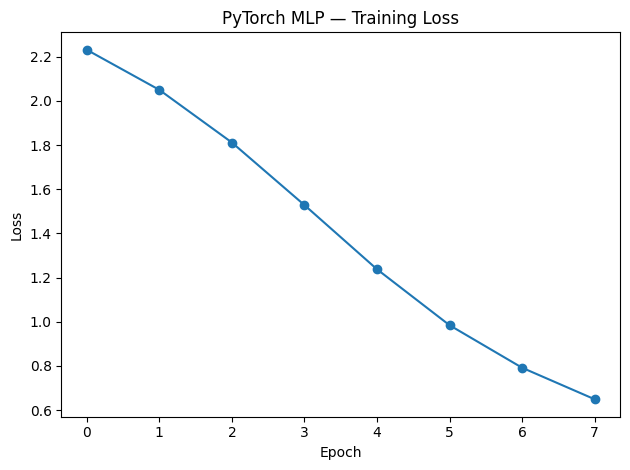

In [21]:
# Re-train a lightweight MLP for a few epochs to capture training loss (does not overwrite main model)
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

try:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader = DataLoader(TensorDataset(torch.tensor(X_train), torch.tensor(y_train)), batch_size=64, shuffle=True)

    class MLPsmall(nn.Module):
        def __init__(self):
            super().__init__()
            self.net = nn.Sequential(nn.Linear(64, 64), nn.ReLU(), nn.Linear(64, 10))
        def forward(self, x): return self.net(x)

    m = MLPsmall().to(device)
    opt = optim.Adam(m.parameters(), lr=1e-3)
    crit = nn.CrossEntropyLoss()

    train_losses = []
    for epoch in range(8):
        m.train()
        total = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad(); out = m(xb); loss = crit(out, yb); loss.backward(); opt.step()
            total += loss.item() * xb.size(0)
        epoch_loss = total / len(train_loader.dataset)
        train_losses.append(epoch_loss)

    plt.figure()
    plt.plot(train_losses, marker='o')
    plt.title("PyTorch MLP — Training Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.tight_layout(); plt.show()
except Exception as e:
    print("Training loss curve skipped:", e)